# 1.Importing the data
     we will take a look at the NYC Airbnb market by combining data from multiple file types like .csv, .tsv, .xlsx.
        Our goals are to analyze, and answer key questions including:
        
       - What is the average price, per night, of an Airbnb listing in NYC?
       - How does the average price of an Airbnb listing, per month, compare to the private rental market?
       - How many adverts are for private rooms?
       - How do Airbnb listing prices compare across the five NYC boroughs?

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

In [25]:
# Load airbnb_price.csv, prices
prices = pd.read_csv(r"C:\Users\karim\Downloads\airbnb_price.csv")

# Load airbnb_last_review.tsv, reviews
reviews = pd.read_csv(r"C:\Users\karim\Downloads\airbnb_last_review.tsv", sep='\t')

# Load airbnb_room_type.xlsx, room_type
room_type = pd.read_excel(r"C:\Users\karim\Downloads\airbnb_room_type (1).xlsx")

In [26]:
print(prices.head())
print('\n')
print(reviews.head())
print('\n')
print(room_type.head())

   listing_id        price                nbhood_full
0        2595  225 dollars         Manhattan, Midtown
1        3831   89 dollars     Brooklyn, Clinton Hill
2        5099  200 dollars     Manhattan, Murray Hill
3        5178   79 dollars  Manhattan, Hell's Kitchen
4        5238  150 dollars       Manhattan, Chinatown


   listing_id    host_name   last_review
0        2595     Jennifer   May 21 2019
1        3831  LisaRoxanne  July 05 2019
2        5099        Chris  June 22 2019
3        5178     Shunichi  June 24 2019
4        5238          Ben  June 09 2019


   listing_id                                description        room_type
0        2595                      Skylit Midtown Castle  Entire home/apt
1        3831            Cozy Entire Floor of Brownstone  Entire home/apt
2        5099  Large Cozy 1 BR Apartment In Midtown East  Entire home/apt
3        5178            Large Furnished Room Near B'way     private room
4        5238         Cute & Cozy Lower East Side 1 bdrm

# 2.Cleaning the price column
    to answer first question the average price per night, we need to detect the type of price column 
    and clean it as per needed:
    1- Wrong type
    2- contains dollars string (not needed in our calculations)
    3- some id's prices = Zero (not needed in our calculations)
    4- we need to compare monthly rental to prive market ( need to add new column )
    

In [27]:
prices['price'].head()

0    225 dollars
1     89 dollars
2    200 dollars
3     79 dollars
4    150 dollars
Name: price, dtype: object

In [28]:
# 1st scenario
prices['price'] = prices['price'].str.replace(' dollars','').astype('int')

# 2nd scenario
prices['price'] = prices['price'].str.rstrip(' dollars').astype('int')

In [29]:
prices['price'].head()

0    225
1     89
2    200
3     79
4    150
Name: price, dtype: int32

In [30]:
prices['price'].describe()

count    25209.000000
mean       141.777936
std        147.349137
min          0.000000
25%         69.000000
50%        105.000000
75%        175.000000
max       7500.000000
Name: price, dtype: float64

there are some outliers including a maximum price of $7,500 per night! 
Some of listings are actually showing as free.
we will drop them before calculating the average 

In [31]:
# Subset prices for listings costing $0, free
free = prices[prices['price'] == 0]

In [32]:
free

,listing_id,price,nbhood_full
10861,20333471,0,"Bronx, East Morrisania"
10958,20523843,0,"Brooklyn, Bushwick"
11023,20639628,0,"Brooklyn, Bedford-Stuyvesant"
11024,20639792,0,"Brooklyn, Bedford-Stuyvesant"
11025,20639914,0,"Brooklyn, Bedford-Stuyvesant"
11577,21291569,0,"Brooklyn, Bushwick"
11589,21304320,0,"Brooklyn, Bushwick"


In [35]:
# Update prices by removing all free listings from prices
prices= prices.drop(free.index)

In [48]:
# Calculate the average price, avg_price
avg_price = prices["price"].mean()
print("The average price per night for an Airbnb listing in NYC is ${:.2f}.".format(avg_price))

The average price per night for an Airbnb listing in NYC is $141.82.


In [ ]:
# to compare our average price to private market 
# We will need to add new column showing rent per month to each listings

In [49]:
# Add a new column to the prices DataFrame, price_per_month
prices["price_per_month"] = prices["price"] * 365 / 12

In [53]:
# Calculate average_price_per_month
average_price_per_month = round(prices["price_per_month"].mean(),2)

In [54]:
# Compare Airbnb and rental market
print("airbnb monthly costs are ${}, while in the private market you would pay {}.".format(average_price_per_month, "$3,100.00"))

airbnb monthly costs are $4313.61, while in the private market you would pay $3,100.00.


# 3.Cleaning the room type column
    diving deeper into the room_type column to find out the breakdown of listings by type of room. 
    we can see some problems already:
    1- Inconsisteny of inputs
    2- using category data type for better analysis

In [56]:
# Convert the room_type column to lowercase
room_type["room_type"] = room_type["room_type"].str.lower()

# Update the room_type column to category data type
room_type["room_type"] = room_type["room_type"].astype("category")

# Create the variable room_frequencies
room_frequencies = room_type["room_type"].value_counts()

In [57]:
room_frequencies

room_type
entire home/apt    13266
private room       11356
shared room          587
Name: count, dtype: int64

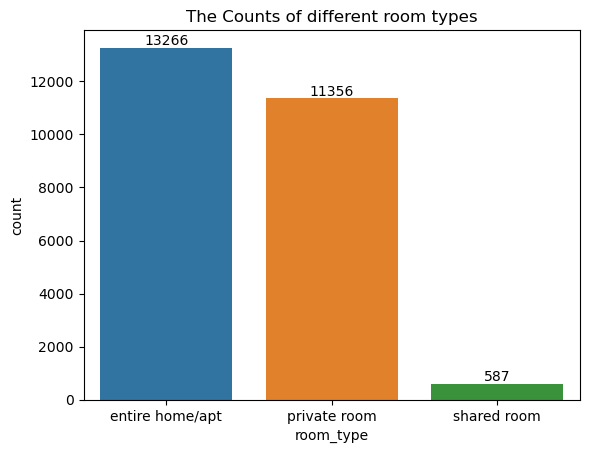

In [59]:
#plot the counts of different room types
ax = sns.countplot(data=room_type,x='room_type')
ax.bar_label(ax.containers[0])
plt.title("The Counts of different room types");

# 4.Set review Dataframe

In [60]:
# Change the data type of the last_review column to datetime
reviews["last_review"] = pd.to_datetime(reviews["last_review"] )

# Create first_reviewed, the earliest review date
first_reviewed = reviews["last_review"].dt.date.min()

# Create last_reviewed, the most recent review date
last_reviewed = reviews["last_review"].dt.date.max()

# Print the oldest and newest reviews from the DataFrame
print("The latest Airbnb review is {}, the earliest review is {}".format(last_reviewed, first_reviewed)) 

The latest Airbnb review is 2019-07-09, the earliest review is 2019-01-01


# 5.Join The DataFrames
    Now we've extracted the information needed, we will merge the three DataFrames to make any future analysis easier to conduct. Once we have joined the data, we will remove any observations with missing values and check for duplicates

In [62]:
# Merge prices and room_types to create rooms_and_prices
rooms_and_prices = prices.merge(room_type, how="outer", on="listing_id")

# Merge rooms_and_prices with the reviews DataFrame to create airbnb_merged
airbnb_merged = rooms_and_prices.merge(reviews, how="outer", on="listing_id")

# Drop missing values from airbnb_merged
airbnb_merged.dropna(inplace=True)

# Check if there are any duplicate values
print("There are {} duplicates in the DataFrame.".format(airbnb_merged.duplicated().sum()))

There are 0 duplicates in the DataFrame.


In [63]:
airbnb_merged.head()

,listing_id,price,nbhood_full,price_per_month,description,room_type,host_name,last_review
0,2595,225.0,"Manhattan, Midtown",6843.750000,Skylit Midtown Castle,entire home/apt,Jennifer,2019-05-21
1,3831,89.0,"Brooklyn, Clinton Hill",2707.083333,Cozy Entire Floor of Brownstone,entire home/apt,LisaRoxanne,2019-07-05
2,5099,200.0,"Manhattan, Murray Hill",6083.333333,Large Cozy 1 BR Apartment In Midtown East,entire home/apt,Chris,2019-06-22
3,5178,79.0,"Manhattan, Hell's Kitchen",2402.916667,Large Furnished Room Near B'way,private room,Shunichi,2019-06-24
4,5238,150.0,"Manhattan, Chinatown",4562.500000,Cute & Cozy Lower East Side 1 bdrm,entire home/apt,Ben,2019-06-09


# 6.Analyze
    Now we have combined all data into a single DataFrame, we will turn our attention to understanding the difference in listing prices between New York City boroughs.

In [83]:
# Extract information from the nbhood_full column and store as a new column, borough
airbnb_merged["borough"] = airbnb_merged["nbhood_full"].str.partition()[0].str.rstrip(',')

In [84]:
airbnb_merged["borough"]

0        Manhattan
1         Brooklyn
2        Manhattan
3        Manhattan
4        Manhattan
           ...    
25197    Manhattan
25198       Queens
25199       Staten
25200        Bronx
25201     Brooklyn
Name: borough, Length: 25184, dtype: object

In [85]:
# Group by borough and calculate summary statistics
boroughs = airbnb_merged.groupby("borough")["price"].agg(["sum", "mean", "median", "count"])

In [90]:
# Round boroughs to 2 decimal places, and sort by mean in descending order
boroughs = round(boroughs,2).sort_values("mean", ascending=False)
boroughs

,sum,mean,median,count
borough,,,,
Manhattan,1898417.0,184.04,149.0,10315
Brooklyn,1275250.0,122.02,95.0,10451
Queens,320715.0,92.83,70.0,3455
Staten,22974.0,86.04,71.0,267
Bronx,55156.0,79.25,65.0,696


# 7.Price range by borough
    The above output gives us a summary of prices for listings across the 5 boroughs. In this final task we would like to categorize listings based on whether they fall into specific price ranges, and view this by borough.

In [91]:
# Create labels for the price range, label_names
label_names = ["Budget", "Average", "Expensive", "Exravagant"]

# Create the label ranges, ranges
ranges = [0, 69, 175, 350, np.inf]

# Insert new column, price_range, into DataFrame
airbnb_merged["price_range"] = pd.cut(airbnb_merged["price"], bins=ranges, labels=label_names)


In [92]:
airbnb_merged["price_range"]

0        Expensive
1          Average
2        Expensive
3          Average
4          Average
           ...    
25197      Average
25198       Budget
25199    Expensive
25200      Average
25201       Budget
Name: price_range, Length: 25184, dtype: category
Categories (4, object): ['Budget' < 'Average' < 'Expensive' < 'Exravagant']

In [93]:
# Calculate borough and price_range frequencies, prices_by_borough
prices_by_borough = airbnb_merged.groupby(["price_range","borough"])["price_range"].count()
print(prices_by_borough)

price_range  borough  
Budget       Bronx         381
             Brooklyn     3194
             Manhattan    1148
             Queens       1631
             Staten        124
Average      Bronx         285
             Brooklyn     5532
             Manhattan    5285
             Queens       1505
             Staten        123
Expensive    Bronx          25
             Brooklyn     1466
             Manhattan    3072
             Queens        291
             Staten         20
Exravagant   Bronx           5
             Brooklyn      259
             Manhattan     810
             Queens         28
             Staten          0
Name: price_range, dtype: int64


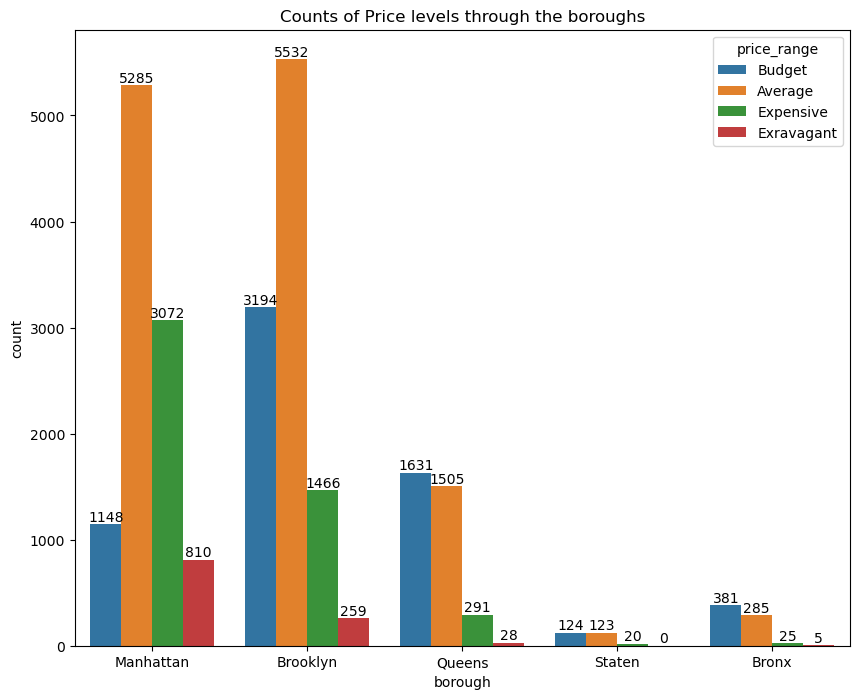

In [96]:
#plot a count plot of the boroughs regarding the different price ranges
plt.figure(figsize=[10, 8])

ax = sns.countplot(data=airbnb_merged, x="borough", hue="price_range", palette=sns.color_palette())
for container in ax.containers:
    ax.bar_label(container, )
plt.title("Counts of Price levels through the boroughs");